In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pystan
import scipy.special as ss
import scipy.stats as st
import seaborn as sns

In [3]:
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

We have set up a simple, mock data set to see if we could possibly detect pre-GRB resonant shattering flares in the aggregate even if there is no confident detection in any particular time series.  

We will generate time-series of counts that are Poisson distributed with some rate per unit time:
$$
n(t) \sim P(\lambda(t)).
$$
The rate, $\lambda(t)$, will be a sum of a constant background rate and a Gaussian surrounding the start time of the flare with width one time unit:
$$
\lambda(t) = \mathrm{const} + \frac{A}{\sqrt{2\pi}} \exp\left[ -\frac{1}{2} \left(t - t_0 \right)^2 \right].
$$

With this choice of parameterization, $A$ is the total number of expected counts in the flare.  Set the origin of time ($t=0$) to the GRB.  Suppose that physics tells us the rough distribution of pre-GRB times for the shattering flares is 
$$
t_0 \sim N(-5, 2)
$$
and that the typical amplitude is $1 \pm 2$ counts:
$$
A \sim N(1, 2)
$$
(but note that $A > 0$).  Further, we will suppose that the background rate is always 1, and that we take 15 measurements of the count leading up to the GRB.

In [4]:
def sigwt(ts, mu, sigma):
    return 0.5*(ss.erf((mu-ts[:-1])/(sigma*sqrt(2))) - ss.erf((mu-ts[1:])/(sigma*sqrt(2))))

In [17]:
nbins = 15
ts = linspace(-nbins, 0, nbins+1)
def generate(nobs):
    data = []
    for i in range(nobs):
        t0 = 1.0
        while t0 > 0:
            t0 = random.normal(-5, 2)
        A = -1.0
        while A < 0:
            A = random.normal(5, 2)
        counts = random.poisson(ones(15) + A*sigwt(ts, t0, 1.0))
        data.append(counts)
    return data

An example of the normalised counts that would be obtained for $t_0 = -5$:

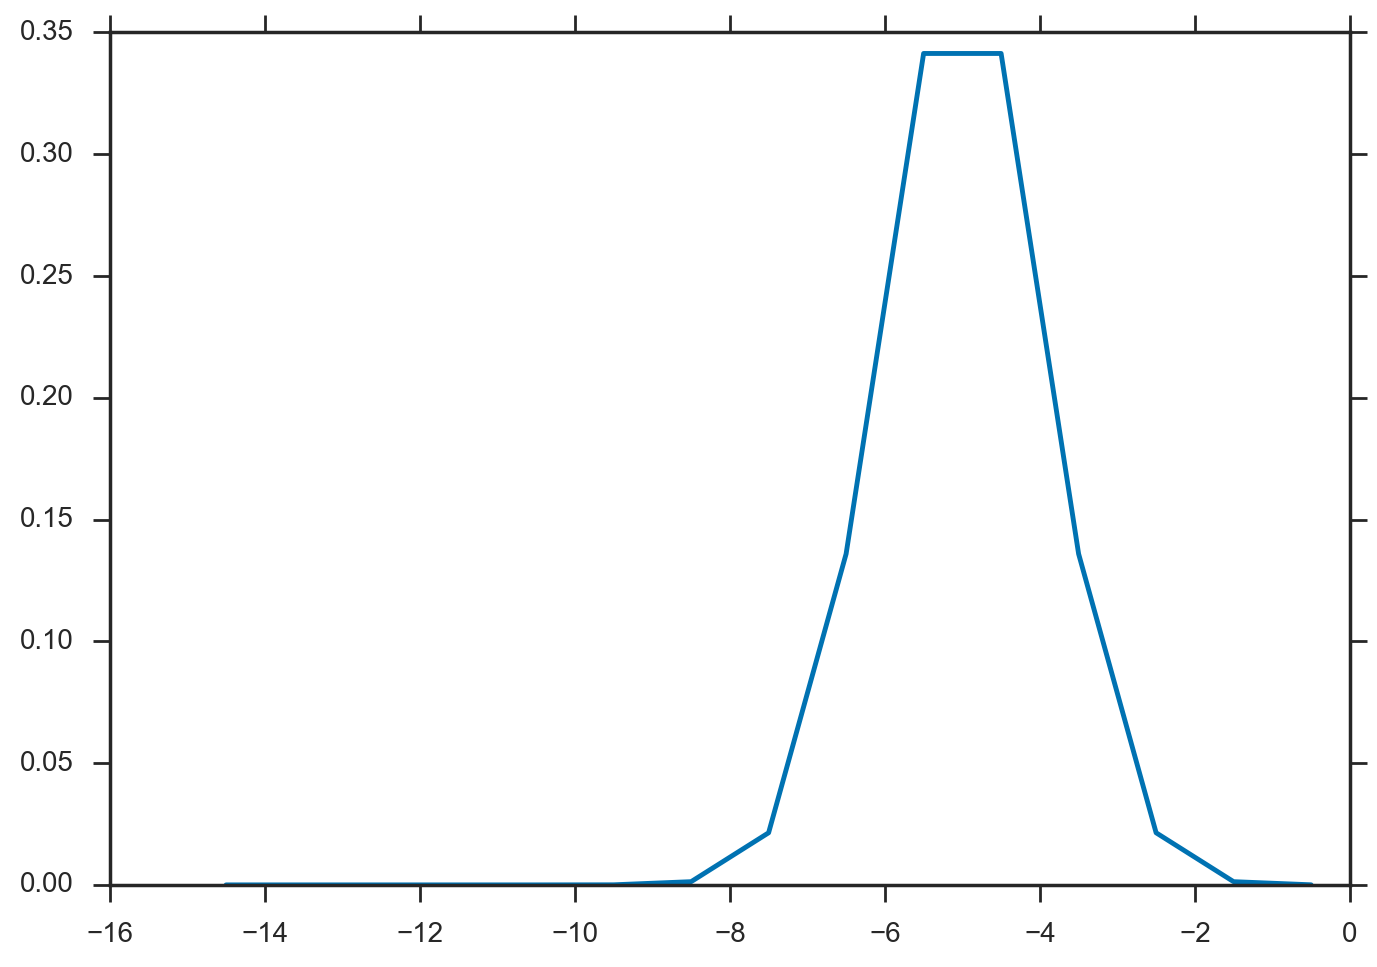

In [18]:
plot(0.5*(ts[:-1]+ts[1:]), sigwt(ts, -5, 1))

Generate some good data:

In [19]:
ctdata = generate(30)

Let's plot the sum of all the counts and the individual curves, to see if we can find an obvious peak:

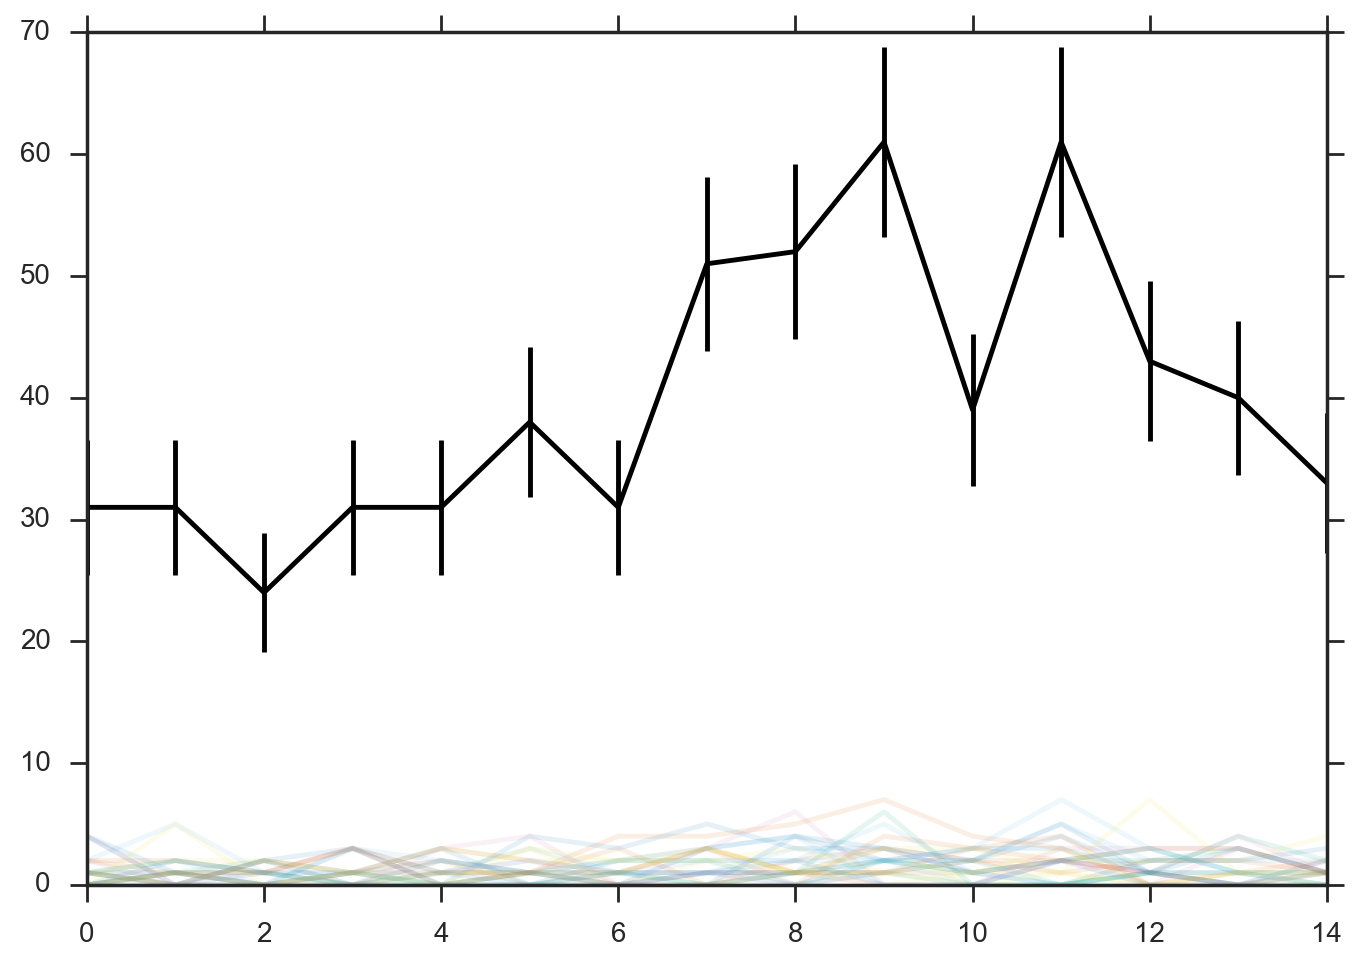

In [20]:
totals = sum(array(ctdata), axis=0)
errorbar(arange(totals.shape[0]), totals, sqrt(totals), fmt='-k')
for d in ctdata:
    plot(d, alpha=0.1)

Let's look for a real signal by summing the totals, weighted by the N(-5, 2) distribution for the position of the peak.

In [21]:
wts = sigwt(ts, -5, 2) # Not really what sigwt is for, but still works
wts = wts / sum(wts)
sig = sum(totals*wts)
bg = sum(totals*(1-wts))/sum(1-wts)
print('sig = {:.1f}, bg = {:.1f}, sigma = {:.1f}'.format(sig, bg, (sig-bg)/sqrt(sig + bg)))

sig = 49.5, bg = 39.1, sigma = 1.1


That's not much of a detection....  The problem is that the width of the distribution of possible signal locations is much wider than the width of a signal itself.  So, if we don't fit the location of the signal in the data, then we have, by necessity, to average over a lot of background....  So, we turn to a hierarchical model, encoded in `flaresearch.stan`.  It uses the "physical" priors on the signal location and imposes a Gaussian prior on the amplitude; if we can bound the mean of that Gaussian significantly above zero, then we have a detection in the aggregate, even if not in any particular instance.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c205d2c7016fc18606c0df9b5227c0d5 NOW.


Inference for Stan model: anon_model_c205d2c7016fc18606c0df9b5227c0d5.
4 chains, each with iter=8000; warmup=4000; thin=4; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bg[0]       1.12    0.01   0.31   0.59   0.91   1.09   1.31   1.79    695   1.01
bg[1]       0.48  3.6e-3   0.19   0.17   0.34   0.46    0.6   0.94   2897    1.0
bg[2]       0.63  4.1e-3   0.24   0.24   0.45    0.6   0.79   1.19   3470    1.0
bg[3]       1.18  5.6e-3   0.31   0.65   0.96   1.14   1.36   1.84   3012    1.0
bg[4]       1.18  6.6e-3    0.3   0.66   0.96   1.15   1.39   1.81   2076    1.0
bg[5]       0.96  6.6e-3   0.29   0.49   0.75   0.94   1.14   1.59   1930    1.0
bg[6]       1.44  7.3e-3   0.36   0.81   1.19   1.42   1.67    2.2   2428    1.0
bg[7]       0.97    0.02   0.29    0.5   0.77   0.94   1.14   1.69    378   1.01
bg[8]        1.0  5.6e-3   0.29   0.49    0.8   0.97   1.18   1.66   2738    1.0
b

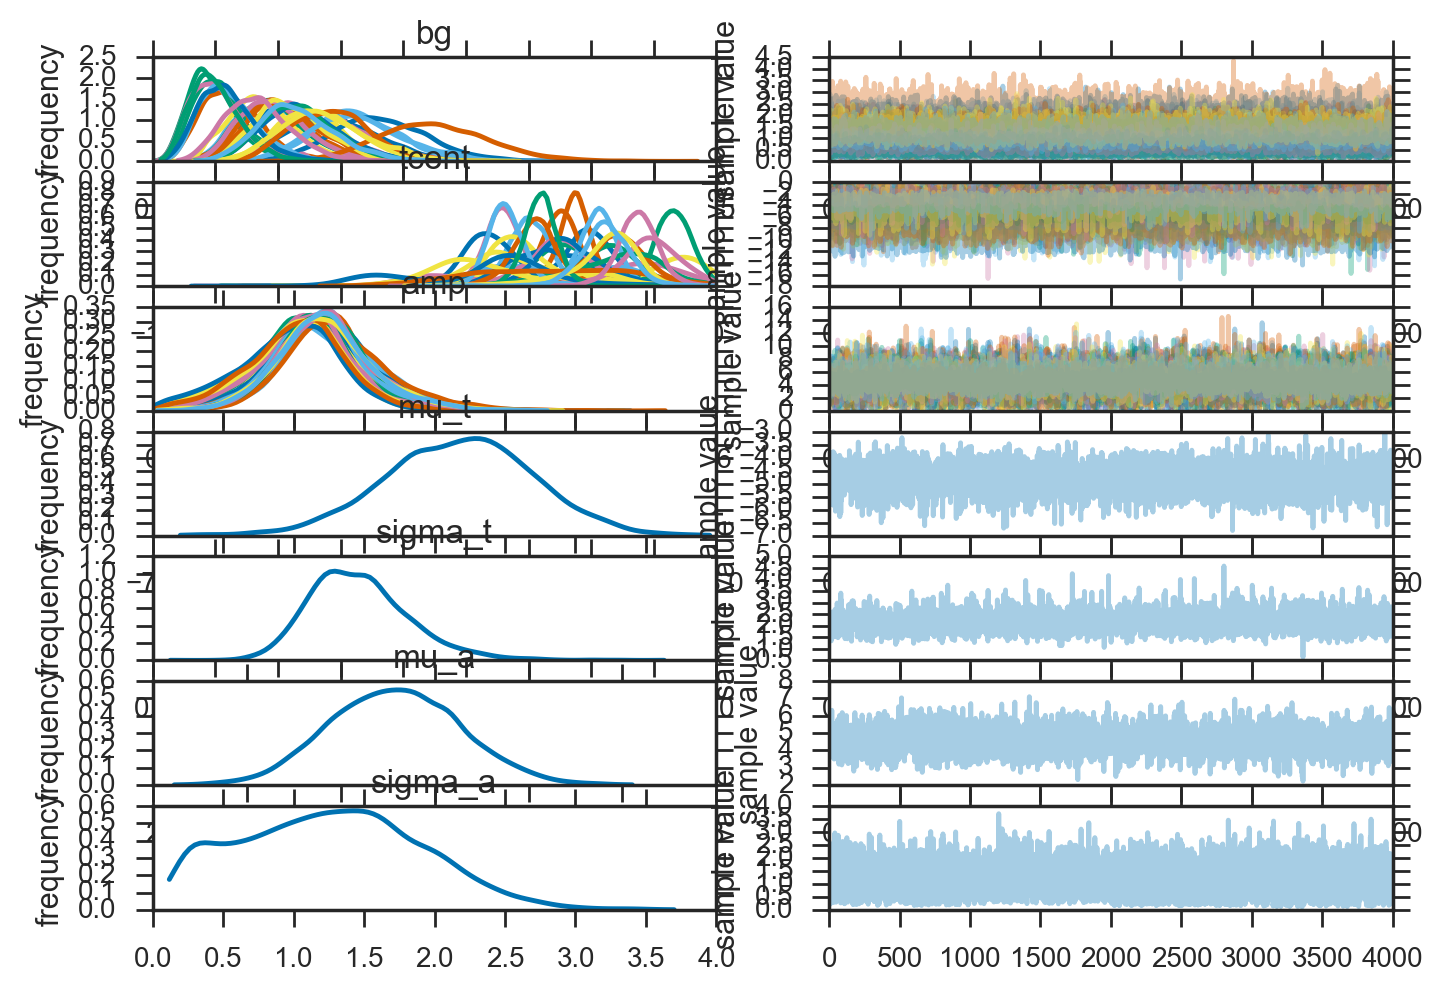

In [26]:
data = {'nt': nbins,
        'nobs': len(ctdata),
        'cts': ctdata}
fit = pystan.stan(file='flaresearch.stan', data=data, iter=8000, thin=4)
fit.plot()
chain = fit.extract(permuted=True)
fit

Whereas before we had a $\sim 1 \, \sigma$ "detection," here we see that we have clear evidence that $\mu_a$ (the centre of the amplitude distribution) is much larger than 0:

/Users/farr/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


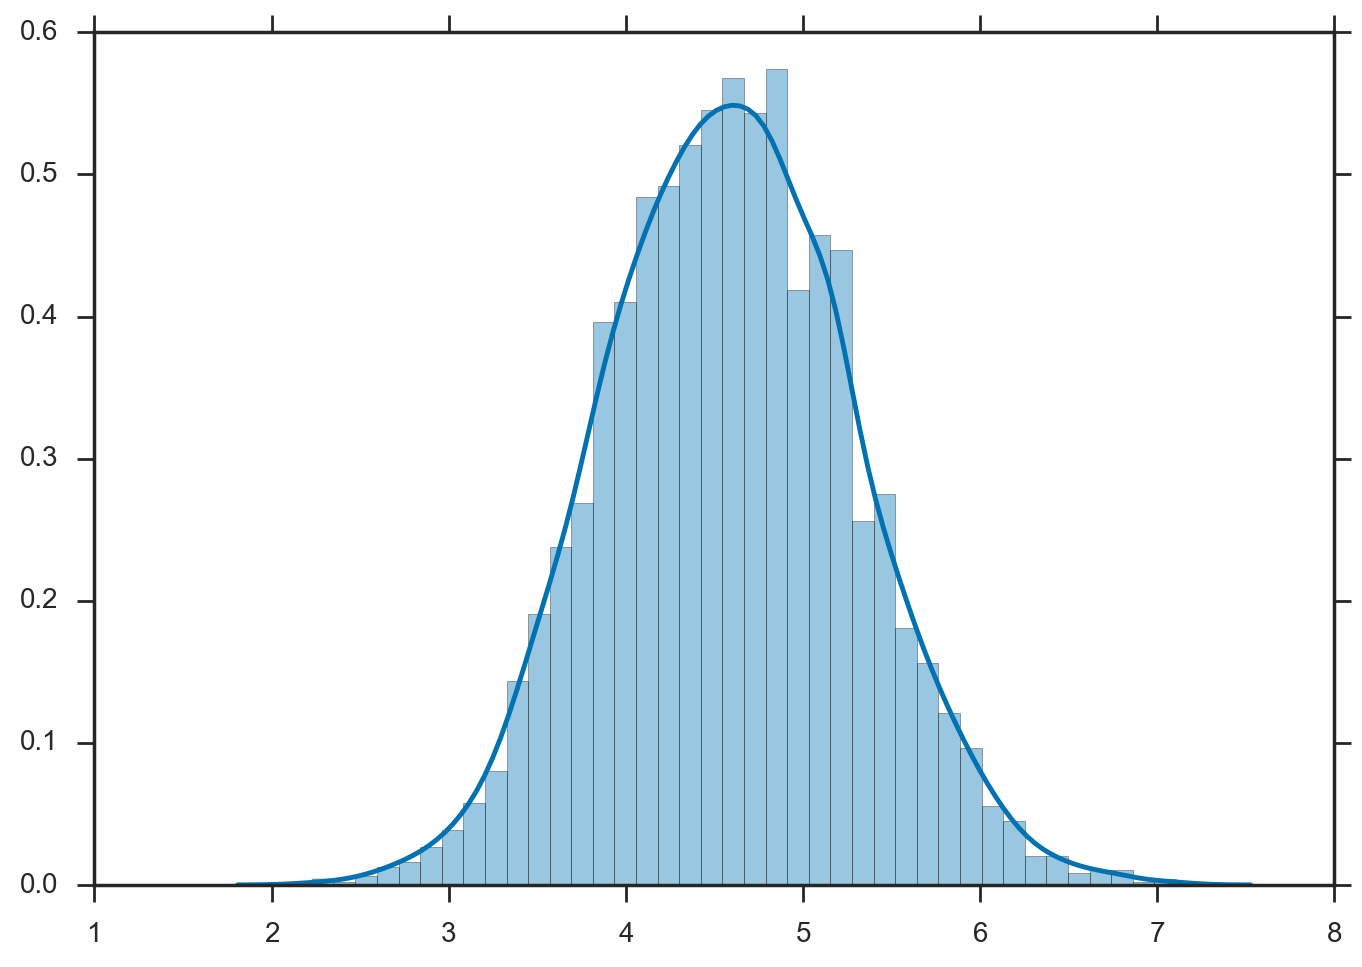

In [28]:
sns.distplot(chain['mu_a'])

This looks pretty Gaussian, so for a quick measure of detection significance, let's compute how many sigma we are from zero:

In [29]:
m = mean(chain['mu_a'])
s = std(chain['mu_a'])
print("We have a {:.1f}-sigma detection.".format(m/s))

We have a 6.6-sigma detection.


One puzzle that I still need to think about: why don't the background fits cluster more closely around 1?  We should have 15 counts on average from the background, which means we should know the level to about 25%, i.e. 1 +/- 0.25, not the +/- 1 that we see below:

/Users/farr/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


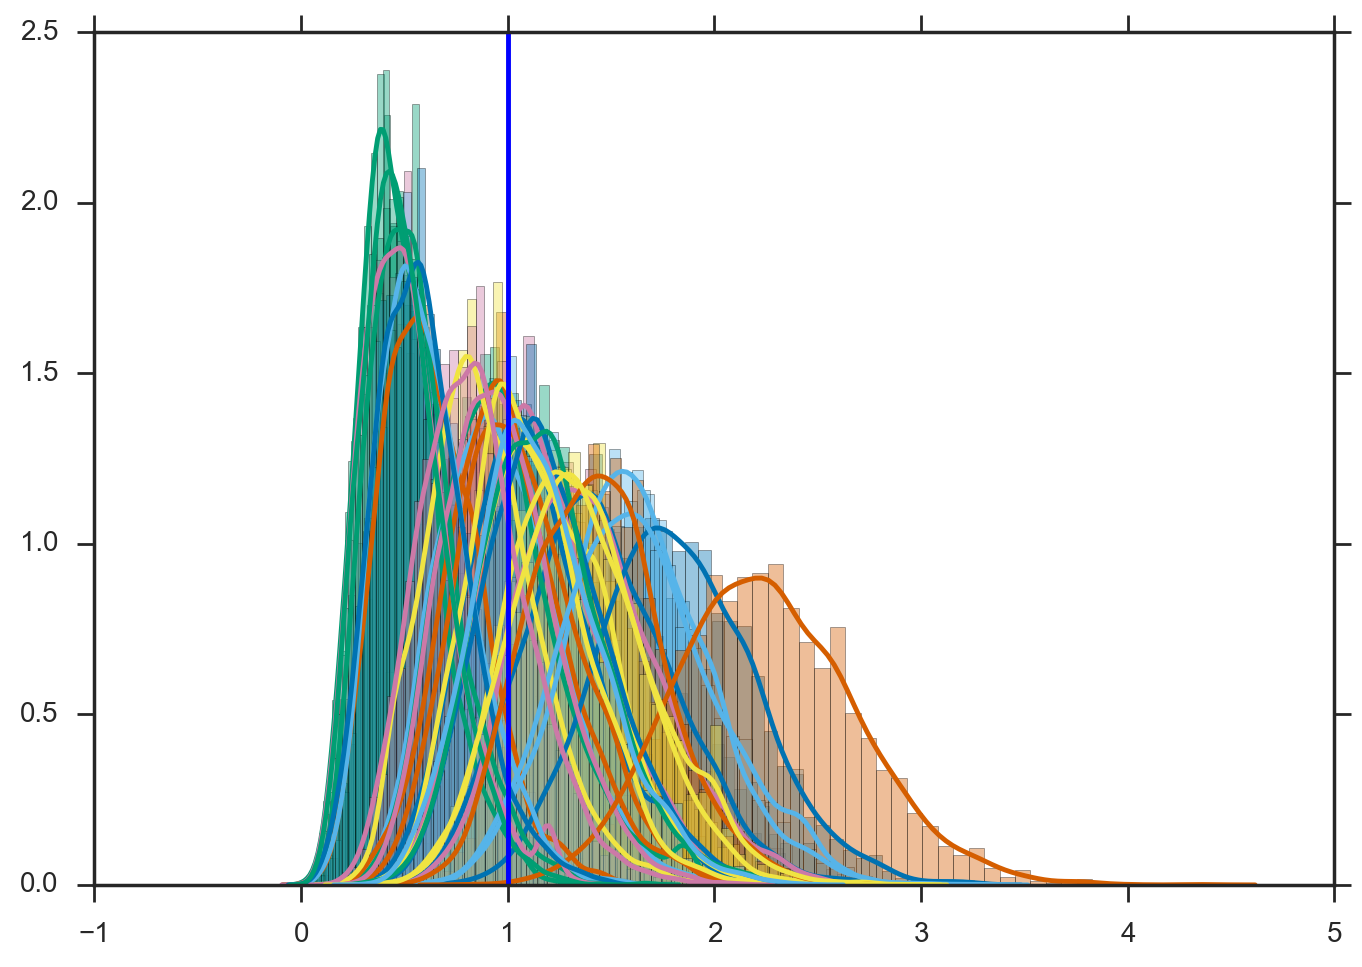

In [33]:
for i in range(len(ctdata)):
    sns.distplot(chain['bg'][:,i])
axvline(1)

Here are the actual amplitudes of the flares, observation by observation (we don't learn much more than that they follow the inferred distribution of amplitudes):

/Users/farr/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


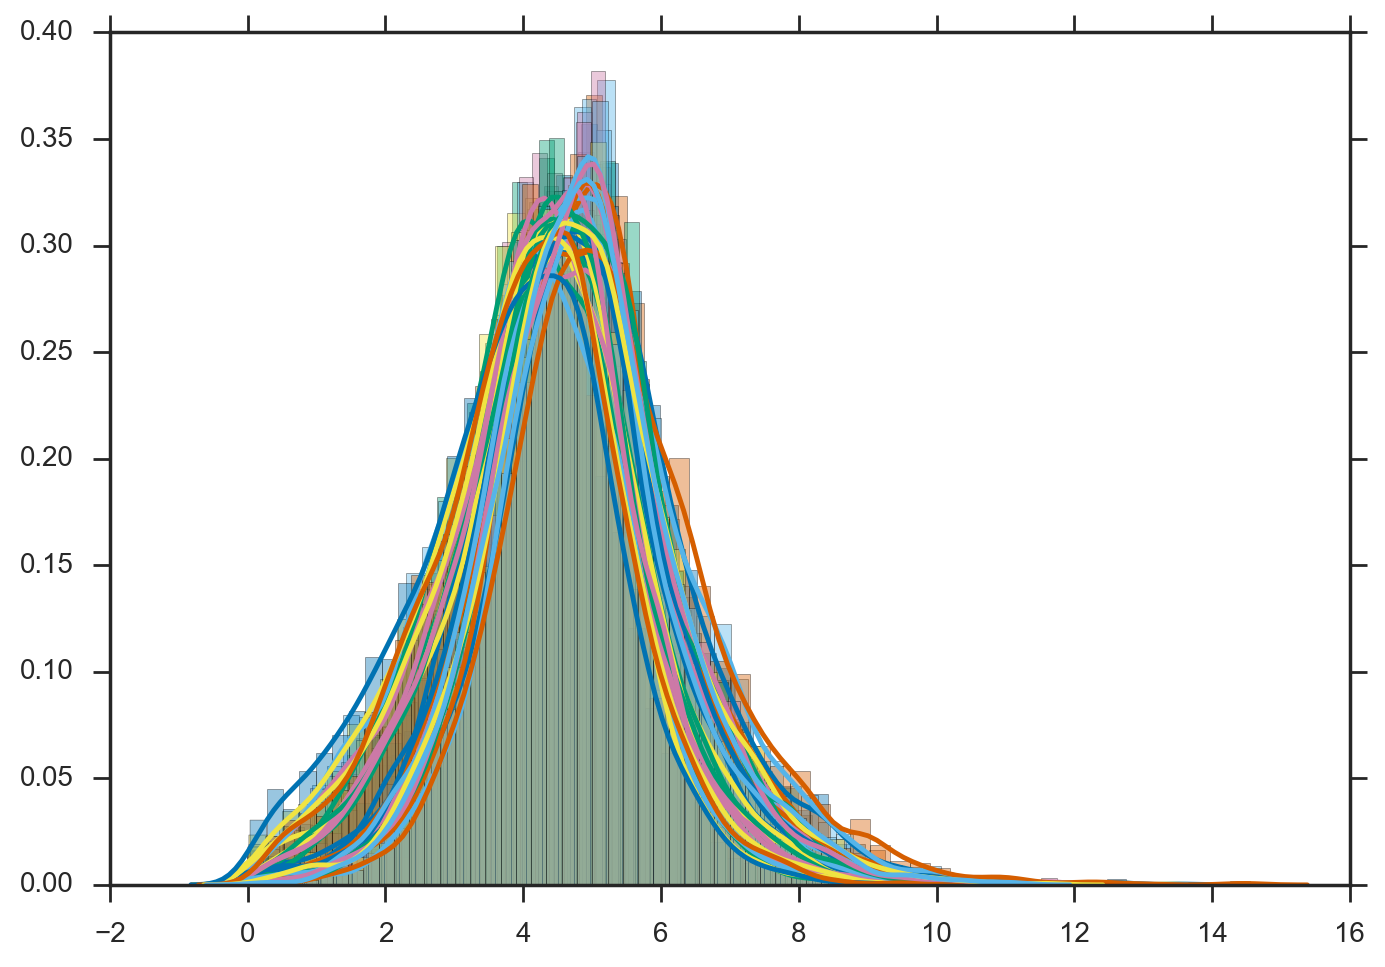

In [34]:
for i in range(len(ctdata)):
    sns.distplot(chain['amp'][:,i])

And so on....